In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import corner
import dill
import sys, os

In [2]:
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [3]:
from jkepler.kepler import rv_from_elements as getrv

In [4]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
#sns.set_palette('colorblind')
from matplotlib import rc
rc('text', usetex=True)

In [5]:
%matplotlib inline

In [6]:
datadir = "data/"
datafile = "v723mon_s12_rv.csv"

In [7]:
rvdata = pd.read_csv(datadir+datafile)
t, y, yerr = jnp.array(rvdata.BJD), jnp.array(rvdata.rv), jnp.array(rvdata.rv_err)
idx = t!=2454073.62965 # bad data
t, y, yerr = t[idx], y[idx], yerr[idx]
tepoch = t[0]
t -= tepoch
print ('# number of data points:', len(t), '\n# epoch (BJD):', tepoch)

# number of data points: 86 
# epoch (BJD): 2454065.57926


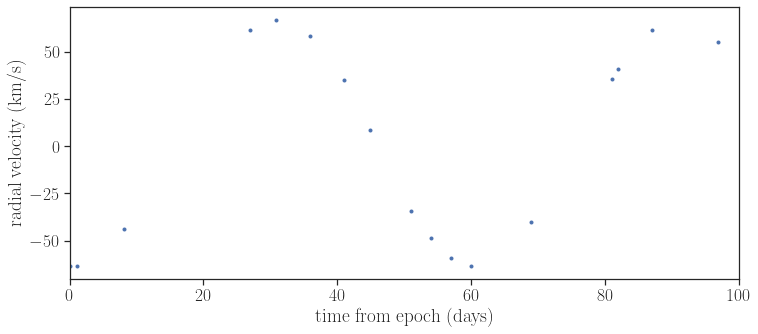

In [8]:
# where's the inferior conjunction?
plt.figure(figsize=(12,5))
plt.xlim(0, 100)
plt.xlabel("time from epoch (days)")
plt.ylabel("radial velocity (km/s)")
plt.plot(t, y, '.');

In [9]:
# initial guess for period and time of inferior conjunction
period_guess = 59.94
t0_guess = (25, 75)
emax = 1.

In [10]:
def model(t, y, yerr):
    logK = numpyro.sample("logK", dist.Uniform(-5, 5))
    K = 10**logK

    ecc = numpyro.sample("ecc", dist.Uniform(0, emax))

    cosw = numpyro.sample("cosw", dist.Normal())
    sinw = numpyro.sample("sinw", dist.Normal())
    omega = jnp.arctan2(sinw, cosw)

    #period = numpyro.sample("period", dist.Uniform(period_guess*0.99, period_guess*1.01))
    period = numpyro.sample("period", dist.TruncatedNormal(low=period_guess-1, loc=period_guess, scale=0.01*period_guess))
    
    t0 = numpyro.sample("t0", dist.Uniform(t0_guess[0], t0_guess[1]))
    #f0 = jnp.pi * 0.5 - omega
    #u0 = 2 * jnp.arctan( jnp.sqrt((1.-ecc)/(1.+ecc)) * jnp.tan(f0*0.5) )
    tanw2 = jnp.tan(0.5 * omega)
    u0 = 2 * jnp.arctan( jnp.sqrt((1.-ecc)/(1.+ecc)) * (1.-tanw2)/(1.+tanw2) )
    tau = t0 - 2*jnp.pi/period*(u0 - ecc*jnp.sin(u0))
    numpyro.deterministic("tau", tau)
    
    numpyro.deterministic("K", K)
    numpyro.deterministic("omega", omega)
    
    
    cosi, lnode = 0, 0
    #_, _, _, vz = xyzv(t, period, ecc, jnp.arccos(cosi), omega, lnode, tau)
    vz = getrv(t, period, ecc, jnp.arccos(cosi), omega, lnode, tau)

    gamma = numpyro.sample("gamma", dist.Uniform(low=-30, high=30))
    
    rvmodel_base = K * vz
    rvmodel = rvmodel_base + gamma
    res = y - rvmodel
    numpyro.deterministic("rvmodel", rvmodel)
    numpyro.deterministic("rvmodel_base", rvmodel_base)

    lnjit = numpyro.sample("lnjit", dist.Uniform(low=-5, high=0))
    jit = jnp.exp(lnjit)
    sigma2 = jit**2 + yerr**2
    lnsigma2 = jnp.log(sigma2)
    loglikelihood = -0.5 * jnp.sum(res**2/sigma2 + lnsigma2)
    numpyro.factor("loglike", loglikelihood)

In [11]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.95)

In [12]:
n_wm = 2000
n_sample = 5000

In [13]:
mcmc = numpyro.infer.MCMC(kernel, num_warmup=n_wm, num_samples=n_sample)

In [14]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, t, y, yerr, extra_fields=('potential_energy',))

sample: 100%|██████████████████████████| 7000/7000 [02:05<00:00, 55.81it/s, 511 steps of size 5.42e-03. acc. prob=0.92]


In [15]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      cosw      0.07      0.12      0.06     -0.11      0.26    995.00      1.00
       ecc      0.02      0.00      0.02      0.01      0.02   2402.54      1.00
     gamma      1.83      0.06      1.83      1.74      1.92   2777.84      1.00
     lnjit     -0.90      0.10     -0.90     -1.07     -0.75   1835.89      1.00
      logK      1.82      0.00      1.82      1.82      1.82   4504.28      1.00
    period     59.94      0.00     59.94     59.93     59.94   4631.00      1.00
      sinw      1.33      0.64      1.25      0.31      2.25   1385.56      1.00
        t0     45.21      0.71     45.22     44.03     46.33   1388.56      1.00

Number of divergences: 238


In [16]:
samples = mcmc.get_samples()

In [17]:
keys = ["tau", "period", "K", "ecc", "omega", "gamma", "lnjit"]
labels = keys

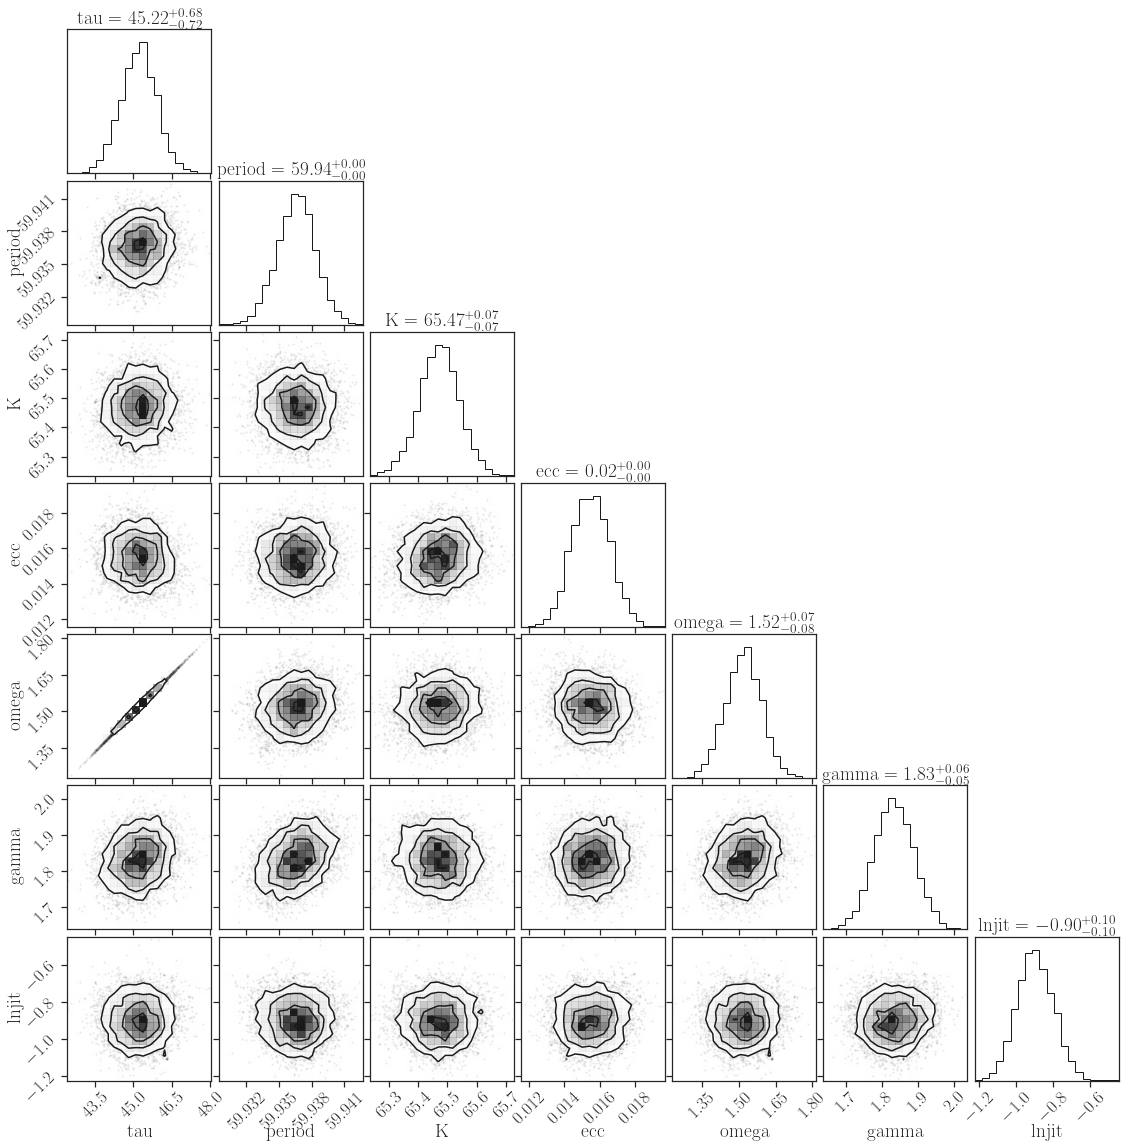

In [18]:
hyper = pd.DataFrame(data=dict(zip(keys, [samples[k] for k in keys])))
fig = corner.corner(hyper, labels=labels, show_titles="%.2f")

In [ ]:
import arviz
fig = arviz.plot_trace(mcmc, var_names=keys)

In [ ]:
from numpyro.infer import Predictive

In [ ]:
predictive = Predictive(model, samples, return_sites=["rvmodel", "rvmodel_base"])

In [ ]:
preds = predictive(rng_key, t=t, y=y, yerr=yerr)

In [ ]:
t2 = np.linspace(t[0], t[-1], 1000)
preds2 = predictive(rng_key, t=t2, y=t2*0, yerr=t2*0)

In [ ]:
mean2, std2 = np.mean(preds2['rvmodel'], axis=0), np.std(preds2['rvmodel'], axis=0)
mean1, std1 = np.mean(preds['rvmodel'], axis=0), np.std(preds['rvmodel'], axis=0)
plt.figure(figsize=(12,5))
plt.ylabel("radial velocity (km/s)")
plt.xlabel("time from epoch (days)")
plt.plot(t, y, 'o')
#plt.plot(t, np.mean(preds['rvmodel'], axis=0), '.')
plt.plot(t2, mean2, '-', label='mean model', color='C1')
plt.fill_between(t2, mean2-std2, mean2+std2, color='C1', alpha=0.4);

In [ ]:
def phasefold(time, flux, t0, period):
    t_fold = (time - t0  + 0.5 * period) % period - 0.5 * period
    index = np.argsort(t_fold)
    return t_fold[index], flux[index]

In [ ]:
t0mean, pmean = jnp.mean(samples['t0']), jnp.mean(samples['period'])
tp, yp = phasefold(t, y, t0mean, pmean)
tp1, yp1 = phasefold(t, mean1, t0mean, pmean)
tp2, yp2 = phasefold(t2, mean2, t0mean, pmean)

In [ ]:
fig, ax = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 2], "hspace": 0.05}, sharex=True, figsize=(15,9))
ax[0].set_xlim(-0.5*pmean, 0.5*pmean)
ax[0].plot(tp, yp, 'o')
ax[0].plot(tp2, yp2, '-', zorder=-1000, label='mean model')
ax[0].legend(loc='best')
ax[1].plot(tp, yp-yp1, 'o')
ax[1].axhline(y=0, color='C1', alpha=0.4)
ax[0].set_ylabel("radial velocity (km/s)")
ax[1].set_ylabel("residual (km/s)")
ax[1].set_xlabel("time from epoch (days)");